# Band Covariance

## For a set of images

Let's take three bands of `LANDSAT/LC8_L1T_TOA` image collection on an specific polygon between two dates. With clouds masked on these polygons

In [1]:
import ee
import datetime

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

imageCollection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')

geom_valencia = ee.Geometry.Polygon([[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]])

start = ee.Date('2015-04-29')
finish = ee.Date('2015-05-20')

def recortar (imagen):
  return imagen.clip(geom_valencia)


def cloudMask(img):
  cloudscore = ee.Algorithms.Landsat.simpleCloudScore(img).select('cloud')
  return img.updateMask(cloudscore.lt(50))

filteredCollection = imageCollection.filterBounds(geom_valencia) \
   .filterDate(start, finish) \
   .sort("system:time_start")

filteredCollection = filteredCollection.map(recortar)

filteredCollection = filteredCollection.map(cloudMask).select('B[2-4]')

ImportError: No module named ee

Compute covariance for each element of the image. We have to attach the covariance to the image. Afterwards we retrieve the set of matrices with `aggregate_array`.

In [2]:
def getCovVar(img):
    arrays = img.toArray();
    #Compute the covariance of the bands within the region.
    covar = arrays.reduceRegion(ee.Reducer.covariance(), geom_valencia, 30)
    return img.set("covar",covar.get('array'))

band_covariance_img = filteredCollection.map(getCovVar).aggregate_array("covar")

We have to call `getInfo` to get the python native list. Until we call it the type of the above operation is `ComputedObject`.

In [3]:
print(type(band_covariance_img))
covariance = band_covariance_img.getInfo()
print(type(covariance))

covariance

<class 'ee.computedobject.ComputedObject'>
<type 'list'>


[[[0.0009491595647197623, 0.0012747739989047951, 0.0017456576952843946],
  [0.0012747739989047951, 0.001969901284463804, 0.0028135991683960605],
  [0.0017456576952843946, 0.0028135991683960605, 0.004287112045996306]],
 [[0.0008269522374230381, 0.001123971829110717, 0.0015265834867083093],
  [0.001123971829110717, 0.0017795764047096121, 0.0025413372926134546],
  [0.0015265834867083093, 0.0025413372926134546, 0.0038919122632120446]],
 [[0.0008129706521811155, 0.001104840850344917, 0.0015006207468866166],
  [0.001104840850344917, 0.0017488723347287728, 0.0024976858026066807],
  [0.0015006207468866166, 0.0024976858026066807, 0.0038252505095261002]],
 [[0.0013305882926820552, 0.0018298117407807065, 0.0025534505569303275],
  [0.0018298117407807065, 0.002738690533203634, 0.003932885030055124],
  [0.0025534505569303275, 0.003932885030055124, 0.005989396051241192]]]

We can now use `numpy` to add the covariance matrices along time dimension

In [4]:
import numpy as np

cov = np.asanyarray(covariance)
print(cov.shape)

suma = np.sum(cov,axis=0)
print(suma.shape)

print(suma)

cov[0,:,:]+cov[1,:,:]+cov[2,:,:]+cov[3,:,:]

(4, 3, 3)
(3, 3)
[[ 0.00391967  0.0053334   0.00732631]
 [ 0.0053334   0.00823704  0.01178551]
 [ 0.00732631  0.01178551  0.01799367]]


array([[ 0.00391967,  0.0053334 ,  0.00732631],
       [ 0.0053334 ,  0.00823704,  0.01178551],
       [ 0.00732631,  0.01178551,  0.01799367]])

## Cross-Band Covariance 
Let $\{X_{bt}\}$ our set of images being $b$ the band index $b\in\{1..B\}$  and $t$ time index. what we did so far is computing covariance between bands: $cov(X_{b_it},X_{b_jt})$ $b_i,b_j \in\{1..B\}$. We can also compute covariance between consecutive time steps:
$cov(X_{b_it},X_{b_jt-1})$.

### Lagged `imgCollection`

In order to do that we can generate the serie with a lagged element $\{[X_{bt},X_{bt-1}]\}$.

We will do that with our custom function `ee_ipl_uv.AddLags`.

In [5]:
# dir() to get defined objects in the current namespace (i.e. variables we have defined so far)
from ee_ipl_uv import time_series_operations
from ee_ipl_uv import download

lagged_list = time_series_operations.AddAllLags(filteredCollection)

To check wether is working or as we expect we will download and show the first image.

In [6]:
image = ee.Image(lagged_list.get(0))

print("Band names:", image.bandNames().getInfo())

fecha = datetime.datetime.utcfromtimestamp(image.get("system:time_start").getInfo()/1000)

print("Fecha ultima imagen accumulate: ",fecha.strftime("%Y-%m-%d %H:%M:%S"))

('Band names:', [u'B2', u'B3', u'B4', u'B2_lag_1', u'B3_lag_1', u'B4_lag_1'])
('Fecha ultima imagen accumulate: ', '2015-05-06 10:42:20')


In [7]:
img_dir = download.MaybeDownload(image,image_name_dir = "img_prueba_lags",remove_zip = False)

tiffs,np_image = download.ReadImage(img_dir)
print(tiffs)
print(np_image.shape)
# Load the layers in RGB order
np_image_current = np_image[:,:,[4,2,0]]
np_image_lagged = np_image[:,:,[5,3,1]]
print(np_image_current.shape)
print(np_image_lagged.shape)

['img_prueba_lags/LC81990322015126LGN00.B2.tif', 'img_prueba_lags/LC81990322015126LGN00.B2_lag_1.tif', 'img_prueba_lags/LC81990322015126LGN00.B3.tif', 'img_prueba_lags/LC81990322015126LGN00.B3_lag_1.tif', 'img_prueba_lags/LC81990322015126LGN00.B4.tif', 'img_prueba_lags/LC81990322015126LGN00.B4_lag_1.tif']
(574, 689, 6)
(574, 689, 3)
(574, 689, 3)


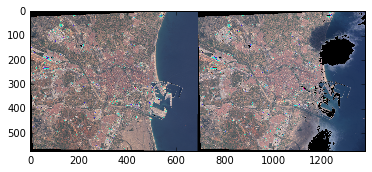

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.concatenate((np_image_current,np_image_lagged),axis=1),clim=(0,.3))

As we can see the lagged image is our well known image with the cloud masked. The current image corresponds to `fecha` timestamp.  It has no clouds. 

Let's see the right image is our first image in the `filteredCollection` object. We will use `getThumbURL` together with `Ipython.display` module. `getThumbURL` will save us to download the full `tiff` raster (GEE will compress the image to the specified size and format) 

In [9]:
from IPython import display
# Example taken from https://groups.google.com/forum/#!topic/google-earth-engine-developers/IT29rJwIVKk
first_image = ee.Image(filteredCollection.first())

# Since .getThumbURL() doesn't accept visualization parameters,
#   use .visualize() instead
# Visuzlize didn't work when I passed the parameters in as a dictionary
image_rgb = first_image.visualize(
    bands=['B4','B3','B2'], max=.3, 
    #palette=['0000FF', '00FFFF', 'FFFF00', 'FF0000'], 
    forceRgbOutput=True)
display.Image(url=image_rgb.getThumbURL({'format': 'jpg', 'size': '600'}))


### Cross-Band-Covariance computation

We just have to call our previously defined `getCovVar` function. Notice that we have lost the first element in our serie. We have 3 covariance matrices instead of 4 as we had before. It is because first image don't have previous element element.

In [10]:
cross_band_covariance = ee.ImageCollection(lagged_list).map(getCovVar).aggregate_array("covar")
cross_band_covariance = cross_band_covariance.getInfo()
print(type(cross_band_covariance))

cb_cov = np.asanyarray(cross_band_covariance)
print(cb_cov.shape)
cb_cov

<type 'list'>
(3, 6, 6)


array([[[ 0.00079464,  0.00106998,  0.00145218,  0.00072186,  0.00098193,
          0.00135828],
        [ 0.00106998,  0.00168722,  0.00240648,  0.00100977,  0.00159079,
          0.0023044 ],
        [ 0.00145218,  0.00240648,  0.00369195,  0.00139636,  0.00231659,
          0.00358208],
        [ 0.00072186,  0.00100977,  0.00139636,  0.00094874,  0.00127421,
          0.00174513],
        [ 0.00098193,  0.00159079,  0.00231659,  0.00127421,  0.00196912,
          0.00281286],
        [ 0.00135828,  0.0023044 ,  0.00358208,  0.00174513,  0.00281286,
          0.00428654]],

       [[ 0.00081284,  0.00110468,  0.00150046,  0.00081732,  0.00111193,
          0.00150981],
        [ 0.00110468,  0.00174869,  0.00249751,  0.001111  ,  0.00175987,
          0.00251302],
        [ 0.00150046,  0.00249751,  0.0038251 ,  0.00150975,  0.00251485,
          0.00385045],
        [ 0.00081732,  0.001111  ,  0.00150975,  0.00082682,  0.00112381,
          0.00152639],
        [ 0.00111193,  0.001